In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile as tiff
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp
import scipy
import pandas as pd
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import anderson
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import warnings


In [23]:
in_file = r"C:\Users\lizau\Desktop\walker_test\04092024_tetraspecs_fibers_negative_control\aligned\20240904-151843_2_WT_multichannel_aligned_drift_corrected.tif"
basename = os.path.basename(in_file)
basename_noext, ext = os.path.splitext(basename)
out_dir = Path(r"C:\Users\lizau\Desktop\walker_test\04092024_tetraspecs_fibers_negative_control\aligned\out_numerical")
os.makedirs(out_dir, exist_ok=True)

In [24]:
fit_method = "lq"
box_side_length = 9
drift = 0
min_gradient = 1000
px_to_nm = 72
frame_to_s = 0.223

max_link_displacement_px = 2
max_gap = 2
min_tray_length = 3
min_fibre_size = 70

In [25]:
take_only_walkers_on_fibre_trajectory(in_file, out_dir / basename_noext, min_fibre_size=min_fibre_size)

Processing frame 1/2536
Processing frame 101/2536
Processing frame 201/2536
Processing frame 301/2536
Processing frame 401/2536
Processing frame 501/2536
Processing frame 601/2536
Processing frame 701/2536
Processing frame 801/2536
Processing frame 901/2536
Processing frame 1001/2536
Processing frame 1101/2536
Processing frame 1201/2536
Processing frame 1301/2536
Processing frame 1401/2536
Processing frame 1501/2536
Processing frame 1601/2536
Processing frame 1701/2536
Processing frame 1801/2536
Processing frame 1901/2536
Processing frame 2001/2536
Processing frame 2101/2536
Processing frame 2201/2536
Processing frame 2301/2536
Processing frame 2401/2536
Processing frame 2501/2536


In [26]:
new_out_locs = fit_single_molecules(
    out_dir,
    basename,
    fit_method=fit_method,
    box_side_length=box_side_length,
    drift=drift,
    min_gradient=min_gradient,
    px_to_nm=px_to_nm,
)

python -m picasso localize C:\Users\lizau\Desktop\walker_test\04092024_tetraspecs_fibers_negative_control\aligned\out_numerical\20240904-151843_2_WT_multichannel_aligned_drift_corrected.tif --fit-method lq --box-side-length 9  --gradient 1000 --drift 0 --pixelsize 72


In [27]:
locs = pd.read_hdf(new_out_locs, "locs")
locs["mass"] = locs.photons

tray = tp.link(locs, search_range=max_link_displacement_px, memory=max_gap)

# count the length of trajectories
tray_by_particle = tray.groupby(["particle"])
tray["length"] = tray_by_particle["particle"].transform("count")
dwell_time = tray["length"].mean()

print("mean drift ", tp.compute_drift(tray).mean())

# Exclude very short trays
tray = tray.query(f"length>={min_tray_length}")

steps = tray.groupby(["particle"]).apply(get_steps_from_df)
steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)

suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
tray.to_csv(tray_out)
steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
steps.to_csv(steps_out)

#distribution_check = []
steps_matrix = steps[['dx', 'dy']].to_numpy()
num_columns = steps_matrix.shape[1]  
normal_str = ''
for var_idx in range(num_columns):
    anderson_data = anderson(steps_matrix[:, var_idx])
    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    #distribution_check += [is_normal]
    if not is_normal:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} NOT normally distributed at {anderson_data.significance_level[1]}%\n"
    else:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} normally distributed at {anderson_data.significance_level[1]}%\n"
    normal_str += normal 


Frame 2535: 1 trajectories present.
mean drift  y   -0.014931
x   -0.077603
dtype: float32


In [8]:

import matplotlib.animation as animation
import matplotlib.colors as mcolors

stack = skio.imread(f'{out_dir}/{basename_noext}.tif')

cmap_bright = plt.colormaps.get_cmap("Set1")
set1_dict = { particle:cmap_bright(i%9) for i, particle in enumerate(list(set(tray.particle)))}

ims = [] 

fig = plt.figure("FRAMES", dpi=300, frameon=False)
ax = fig.add_subplot(111)

for n in range(stack.shape[0]):
    frame = ax.imshow(stack[n].astype('uint16'), cmap = 'Greys_r')
    if n in list(set(tray.frame)):
        t = []
        for k in list(set(tray[(tray["frame"]==n)].particle)):
            bright_color = set1_dict[k]
            t.append(ax.plot(tray[(tray["frame"]<=n) & (tray["particle"]==k)].x, tray[(tray["frame"]<=n) & (tray["particle"]==k)].y, linewidth=1, color=bright_color))
            plt.axis('off')
        number = ax.annotate(n,(1,1))
        artist_obj = [i[0] for i in t]
        artist_obj.append(frame)
        artist_obj.append(number)
        ims.append(artist_obj)

    else:
        ims.append([frame])
    if n >= 200:
        break

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,repeat_delay=1000)

output_path = f'{out_dir}/{basename_noext}_trajectories.mp4'


ani.save(output_path)




NameError: name 'tray' is not defined

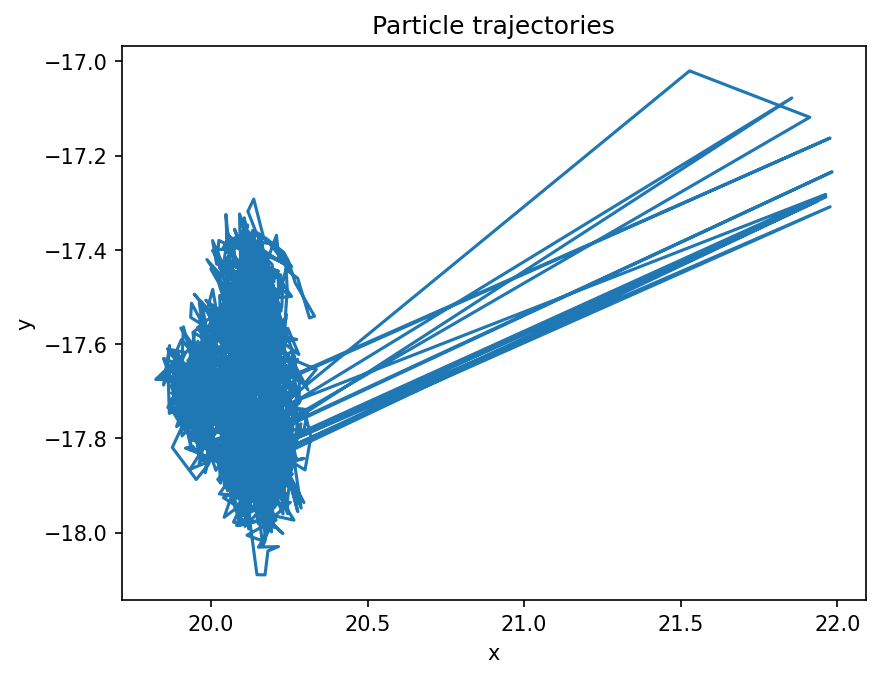

In [28]:
plt.figure()
for i in set(tray.particle):
    plt.plot(tray[tray["particle"]==i].x, tray[tray["particle"]==i].y*-1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Particle trajectories')
plt.savefig(f'{out_dir}/{basename_noext}_trajectories.png')

In [39]:
x = steps['dx']
y = steps['dy']
bins = (75, 70)
hist, xedges, yedges = np.histogram2d(x, y, bins=(75,50), density=True)
xcent = (xedges[1:] + xedges[:-1])/2
ycent = (yedges[1:] + yedges[:-1])/2
x_grid, y_grid = np.meshgrid(xcent, ycent)
xy = np.stack((x_grid.ravel(), y_grid.ravel())).T


In [19]:
x = steps['dx'].to_numpy()
y = steps['dy'].to_numpy()
hist, xedges, yedges = np.histogram2d(x, y, bins=75)

class MultivariateNormal(object):
    def __init__(self):
        self.u_ = None
        self.sig_ = None
    @staticmethod
    def redimx(x): return x[...,np.newaxis] if x.ndim == 2 else x
    def fit(self, x):
        x = self.redimx(x)
        self.u_ = x.mean(0)
        self.sig_ = np.einsum('ijk,ikj->jk', x-self.u_, x-self.u_)/ (x.shape[0]-1)
    def prob(self, x):
        x = self.redimx(x)
        f1 = (2*np.pi)**(-self.u_.shape[0]/2)*np.linalg.det(self.sig_)**(-1/2)
        f2 = np.exp((-1/2)*np.einsum('ijk,jl,ilk->ik', x-self.u_, np.linalg.inv(self.sig_), x-self.u_))
        return f1*f2

def cov_to_axes_and_rotation(cov, sorted=True):
    """"Takes a covariance matrix and returns the principle axes and a rotation"""
    (e1, e2), eigen_vec = np.linalg.eig(cov)
    V1,V2 = eigen_vec.T
    
    # Eigenvectors are assumed to be unit and orthogonal
    # print(np.linalg.norm(V1))
    e1 = np.real(e1) # sometimes tiny imaginary components are returned. 
    e2 = np.real(e2) # sometimes tiny imaginary components are returned. 
    if np.isclose(e1, e2):
        # the angle is not well defined
        theta = 0

    else:
        # Are eigenvectors always normalized? 
        theta = np.degrees(np.arctan2(V1[1], V1[0]))
    #if theta>90 and theta <180:
    #     theta = 180 - theta
    #print(theta)

    if sorted: #make sure e1 is always the largest
        if e2>e1:
            (e1, e2) = (e2, e1)
            theta = theta + 90

    return e1, e2, np.mod(theta, 360)

In [20]:
info = {}
diff_info_out = base_linked_tray.with_suffix(".diff")

mod = MultivariateNormal()
mod.fit(steps_matrix)
print(normal_str)
print(f'the means of multivariate normal distrubution are: mu(dx) = {mod.u_[0][0]:.3f}, mu(dy) = {mod.u_[1][0]:.3f}')
print(f'the standard deviations of the multivariate normal distribution are: sigma(dx) = {mod.sig_[0][0]:.3f}, sigma(dy) = {mod.sig_[1][1]:.3f}')
print(f'the covariance of the multivariate normal distribution is: sigma(dxdy) = {mod.sig_[0][1]:.3f}')


variable dx normally distributed at 10.0%
variable dy normally distributed at 10.0%

the means of multivariate normal distrubution are: mu(dx) = 0.000, mu(dy) = 0.000
the standard deviations of the multivariate normal distribution are: sigma(dx) = 0.002, sigma(dy) = 0.002
the covariance of the multivariate normal distribution is: sigma(dxdy) = -0.000


In [21]:
cov_matrix = mod.sig_
e1, e2, rot = cov_to_axes_and_rotation(cov_matrix)
info["diff_long_nm_nm_s"] = float(e1*(px_to_nm**2)/(2*frame_to_s))
info["diff_short_nm_nm_s"] = float(e2*(px_to_nm**2)/(2*frame_to_s))
info["diff_long_nm_nm_s"] = float(e1*(px_to_nm**2)/(2*frame_to_s))
info["diff_short_nm_nm_s"] = float(e2*(px_to_nm**2)/(2*frame_to_s))
info["time_per_1000nm_s_long_axis"] = 1000 * 1000 / info["diff_long_nm_nm_s"] / 2
info["mean_step_nm_s"] = float(np.sqrt(2 * info["diff_long_nm_nm_s"] * frame_to_s) / frame_to_s)
info["normality_str"] = normal_str
info["anderson_test"] = anderson_data
info["mu_x"] = float(round(mod.u_[0][0], 3))
info["mu_y"] = float(round(mod.u_[1][0], 3))
info["sigma_x"] = float(round(cov_matrix[0][0], 3))
info["sigma_y"] = float(round(cov_matrix[1][1], 3))
info["sigma_xy"] = float(round(cov_matrix[0][1], 3))
write_yaml(info, diff_info_out)

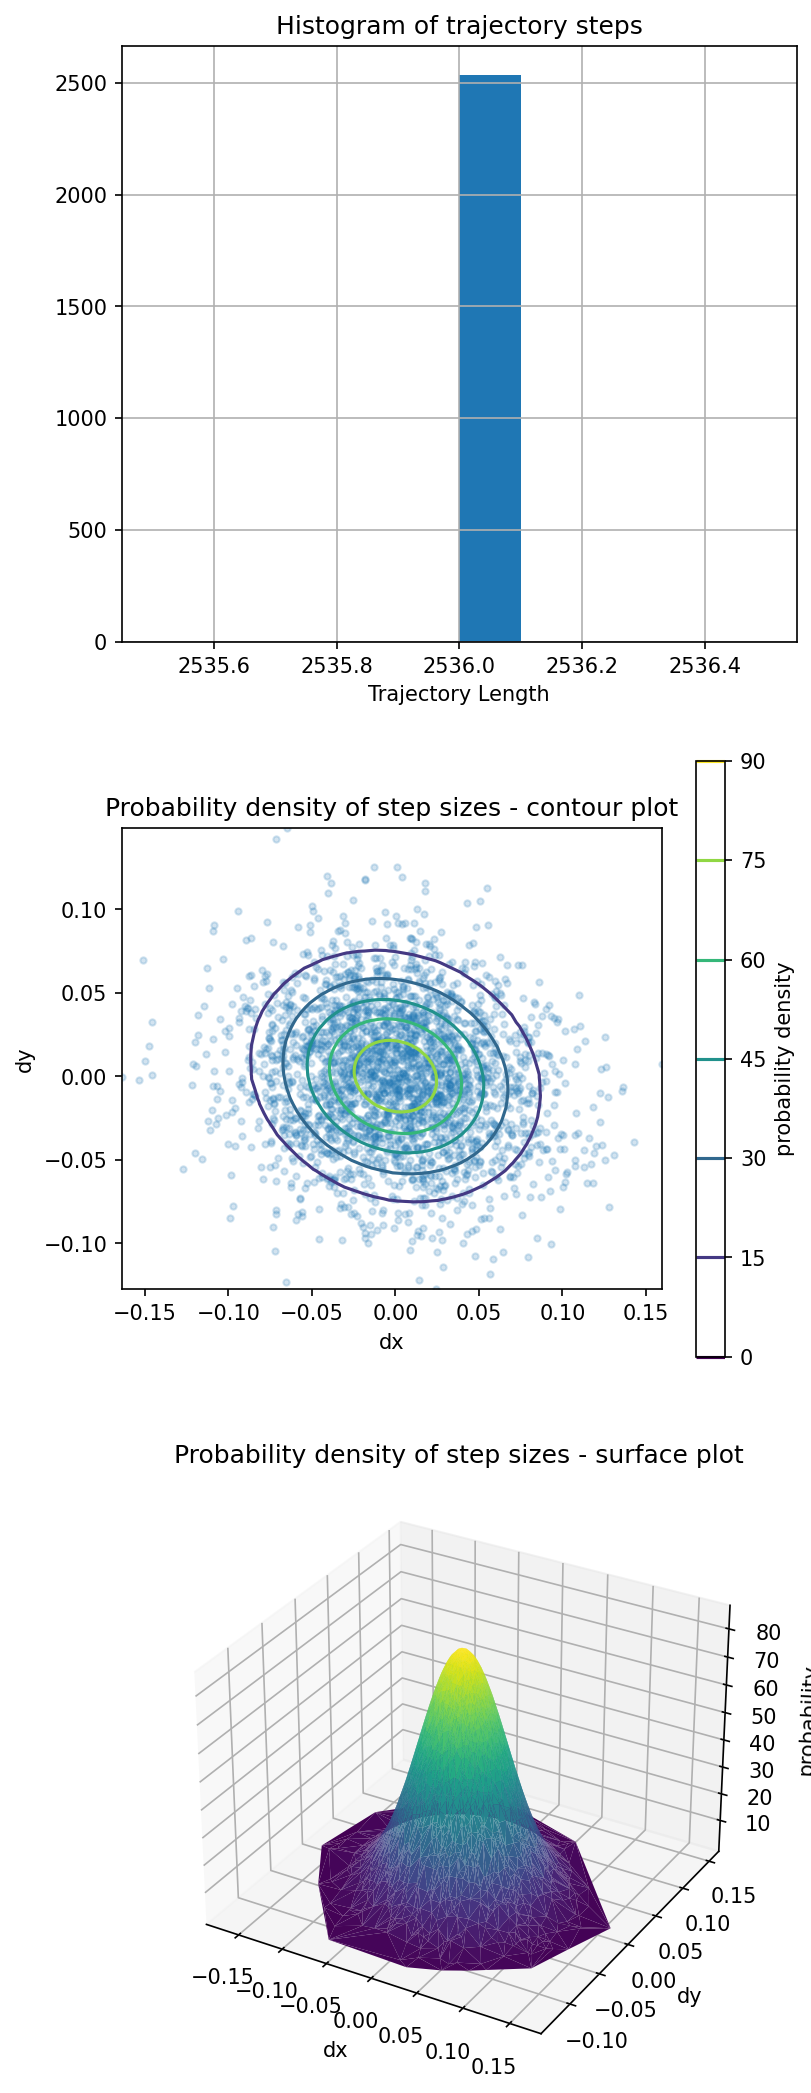

In [22]:
z = mod.prob(steps_matrix)
triang = Triangulation(x, y)
fig = plt.figure(figsize=(5,15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
#ax3 = fig.add_subplot(313)
ax3 = fig.add_subplot(313, projection='3d')
fig.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0) 
plt.sca(ax1)
tray.length.hist()
plt.xlabel("Trajectory Length")
plt.title("Histogram of trajectory steps")
#plt.sca(ax2)
#steps.plot.scatter("dx", "dy", alpha=0.1, ax=ax2)
#plt.title("Size of steps")
plt.sca(ax2)
plt.plot(x,y, '.', alpha = 0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.tricontour(triang, z.ravel(), cmap = 'viridis')
plt.colorbar(label='probability density') 
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('Probability density of step sizes - contour plot')
plt.sca(ax3)
ax3.plot_trisurf(triang, z.ravel(), cmap='viridis')
plt.xlabel('dx')
plt.ylabel('dy')
ax3.set_zlabel('probability')
plt.title('Probability density of step sizes - surface plot')

fig.savefig(f'{out_dir}/{basename_noext}_2d_fit.png')
